In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def i2b(A):
    return torch.tensor(list(map(lambda x : list([int(z) for z in '{0:>04b}'.format(x)]), A)))

def encode(U, G):
    return torch.matmul(U, G)%2

def mod_bpsk(C):
    X = -(2*C-1)
    return X

def awgn(X, SNR):
    Z = torch.randn((X.shape[0], 7))/np.sqrt(SNR)
    Y = X + Z
    return Y

def decode_ml(Y, CB):
    indx = torch.argmin((torch.abs(Y.unsqueeze(1) - CB)**2).sum(axis=2), dim=1)
    U_hat = CB[indx]
    return U_hat

def decode_hard(Y):
    Y = (Y > 0).type(torch.float)
    Y[Y == 0] = -1.0
    return Y

In [3]:
G = torch.tensor([[1, 0, 0, 0, 1, 1, 0],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 0, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1]])

H = torch.tensor([[1, 1, 0, 1, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [0, 1, 1, 1, 0, 0, 1]])

i = torch.arange(0,16)
I = i2b(i)

CB = mod_bpsk(torch.matmul(I, G)%2)

In [4]:
u = torch.randint(0, 16, (10000000,))

In [5]:
U = i2b(u)

In [6]:
db = []
ber_ml = []
ber_hard = []
for snrdb in tqdm(range(-6, 12)):
    SNR = 10**(snrdb/10)
    C = encode(U, G)
    X = mod_bpsk(C)
    Y = awgn(X, SNR)
    U_hat = decode_ml(Y,CB)
    er = (X != U_hat).sum()/(U_hat.shape[0]*U_hat.shape[1])
    
    U_hat_hard = decode_hard(Y)
    er_hard = (X != U_hat_hard).sum()/(U_hat_hard.shape[0]*U_hat_hard.shape[1])
    
    db.append(snrdb)
    ber_ml.append(er)
    ber_hard.append(er_hard)
    

  0%|          | 0/18 [00:00<?, ?it/s]

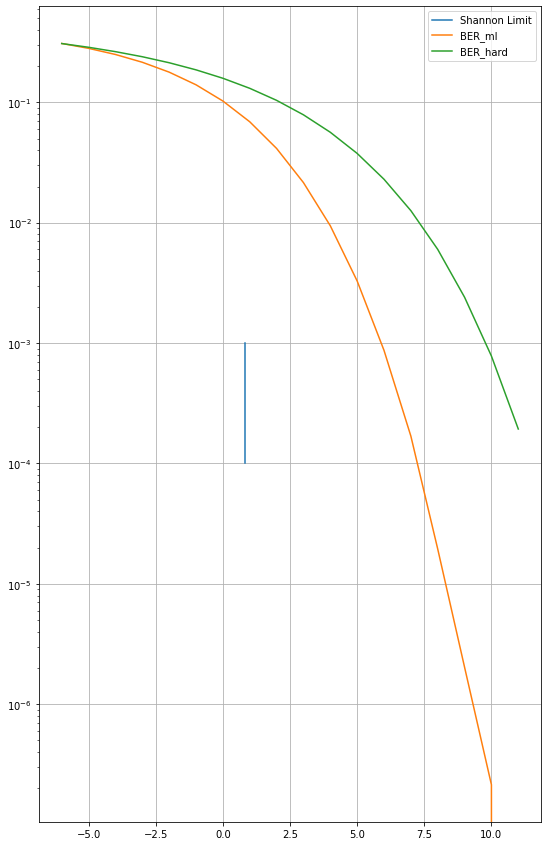

In [7]:
rate = 4/7
shannon_lim = 10.0*np.log10(2.0**(2*rate)-1)

plt.figure(figsize=(9,15), facecolor='white')

plt.semilogy([shannon_lim, shannon_lim], [1e-4,1e-3])
plt.semilogy(db, ber_ml)
plt.semilogy(db, ber_hard)
plt.legend(['Shannon Limit', 'BER_ml', 'BER_hard'])
plt.grid()
plt.savefig('hamming_decoded_by_ml.png')